In [4]:
#import packages
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import pmdarima
from sklearn.metrics import mean_squared_error
from math import sqrt

# results, comparison of RMSE:

In [133]:
#results
results_ = {'Approach': ['Auto_ARIMA','ARIMA','Holt_Winter','Holt_linear',"SES","Moving average","Avergage","Naive"],
        'RSME': [0.441200665870425,0.43386150665562073,0.4372715703638042,0.5682380639642585,0.45290495478736503,0.4326667431472504,0.43881130638411586,0.4827170745183632]
        }
df = pd.DataFrame(results_, columns = ['Approach', 'RSME'])
df= df.sort_values(by='RSME', ascending=False)
df.head(8)

,Approach,RSME
3,Holt_linear,0.568238
7,Naive,0.482717
4,SES,0.452905
0,Auto_ARIMA,0.441201
6,Avergage,0.438811
2,Holt_Winter,0.437272
1,ARIMA,0.433862
5,Moving average,0.432667


In [5]:
dforiginal= pd.read_csv("data_rhein.csv")
dforiginal.head(2)

In [7]:
df0=dforiginal.loc[dforiginal['Kürzel'] == "DI"]
df0['Datum'] = pd.to_datetime(df0['Datum'])
df0=df0.set_index("Datum")
df0.head(2)

C:\Users\raiko\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Unnamed: 0,Kürzel,Status Nr.,Labornummer,Jahr,Dauer,Mittl.Abfluss,Abflussumme,Temp.(BAFU),pH(BAFU),...,Quecksilber,NP,NP1EO,NP2EO,NP3EO,Calcium (IC),Status Nr.,year,month,day
Datum,,,,,,,,,,,,,,,,,,,,,
1984-01-09 09:50:00,1421,DI,NaN,39071.0,1984.0,312.0,110.0,123.96,4.0,8.10,...,NaN,NaN,NaN,NaN,NaN,NaN,4.0,1984,1,9
1984-01-23 09:35:00,1422,DI,NaN,39093.0,1984.0,336.0,111.6,134.77,3.2,8.05,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1984,1,23


In [8]:
df1 = df0[["DOC"]]
df1.head(2)

,DOC
Datum,
1984-01-09 09:50:00,1.0
1984-01-23 09:35:00,0.6


C:\Users\raiko\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


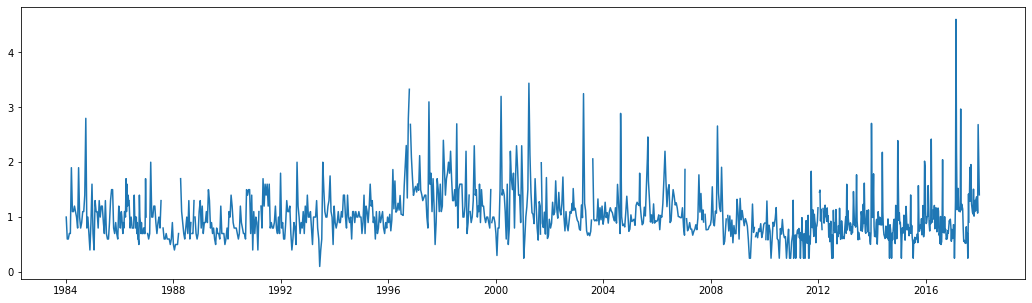

In [9]:
plt.figure(figsize=(18,5))
plt.plot(df1)

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from dateutil.parser import parse

In [11]:
# Transform the dataframe:
ts_log = np.log(df1)# Replace infs with NaN
ts_log.replace([np.inf, -np.inf], np.nan, inplace=True)# Remove all the NaN values
ts_log.dropna(inplace=True)

In [12]:
print ('Results of Dickey-Fuller Test:')
timeseries = ts_log.iloc[:,0].values
dftest = adfuller(timeseries, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                -6.299880e+00
p-value                        3.432903e-08
#Lags Used                     8.000000e+00
Number of Observations Used    1.084000e+03
Critical Value (1%)           -3.436397e+00
Critical Value (5%)           -2.864210e+00
Critical Value (10%)          -2.568192e+00
dtype: float64


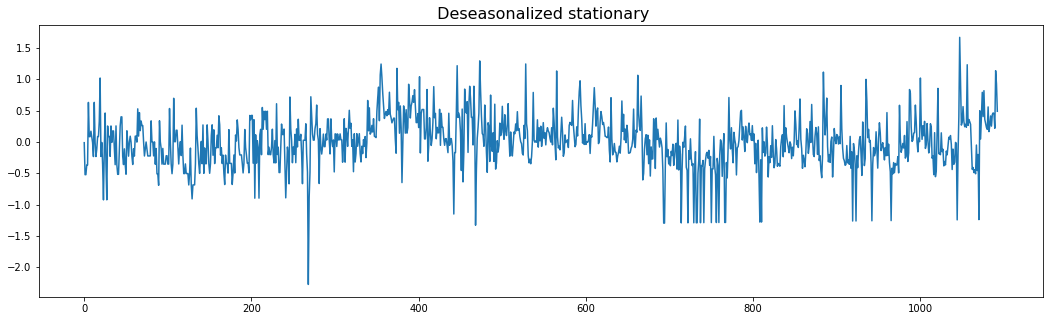

In [13]:
# Using scipy: Subtract the line of best fit
from scipy import signal
detrended = signal.detrend(ts_log.DOC.values)
plt.figure(figsize=(18,5))
plt.title(' Deseasonalized stationary', fontsize=16)
plt.plot(detrended)

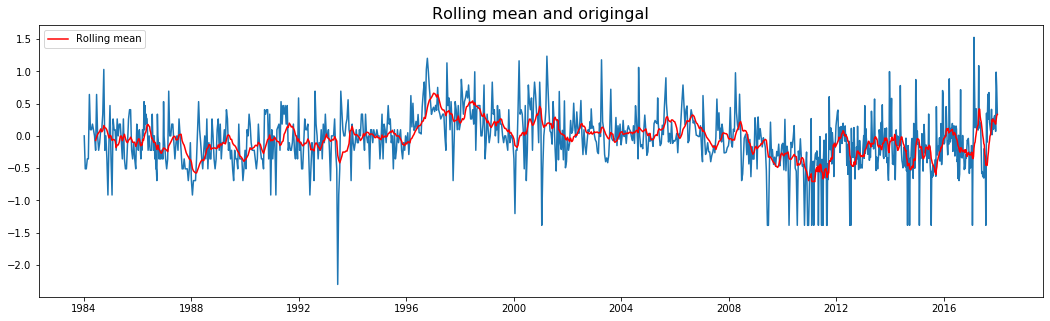

In [14]:
rolmean = ts_log.rolling(window=12).mean()

plt.show(block=False)
plt.figure(figsize=(18,5))
plt.plot(ts_log)

plt.title('Rolling mean and origingal', fontsize=16)
plt.plot(rolmean, color="red", label="Rolling mean")
plt.legend(loc="best")

C:\Users\raiko\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: the 'freq' keyword is deprecated, use 'period' instead
  after removing the cwd from sys.path.


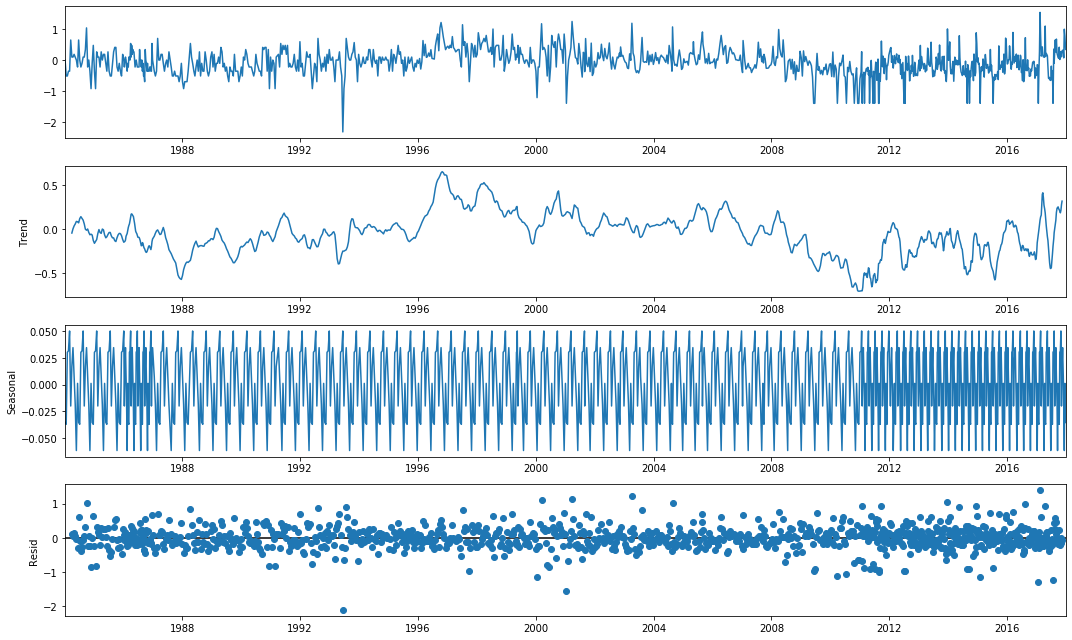

In [15]:
#decompostion with ts_log and additive model
from pylab import rcParams
rcParams['figure.figsize'] = 15, 9
result = seasonal_decompose(ts_log, model='additive', freq=12)
fig = result.plot()
plt.show()

________________________________________________________________________________________________________________________


In [16]:
number_observations = ts_log.shape[0]
index = int(0.8 * number_observations)
train = ts_log.iloc[:index, :]
test = ts_log.iloc[index:]

In [105]:
pff=train.describe()
print("count DOC values train:",pff.at["count","DOC"])

pf=test.describe()
print("count DOC values test: ",pf.at["count","DOC"])

count DOC values train: 874.0
count DOC values test:  219.0


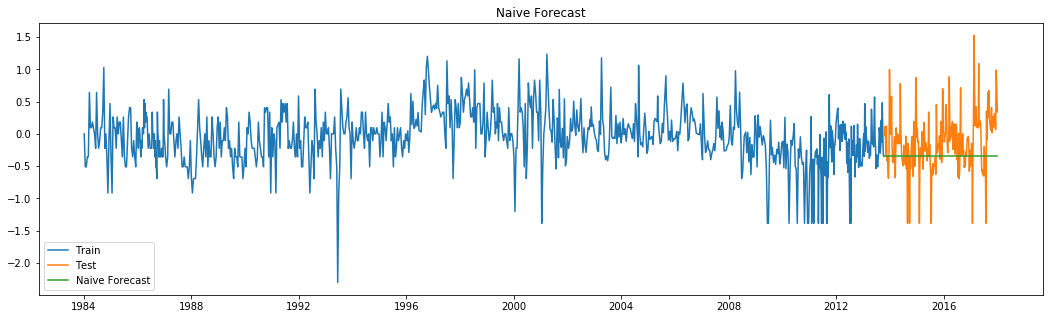

In [18]:
#prediction naive approach
dd= np.asarray(train.DOC)
y_hat = test.copy()
y_hat['naive'] = dd[len(dd)-1]
plt.figure(figsize=(18,5))
plt.plot(train.index, train['DOC'], label='Train')
plt.plot(test.index,test['DOC'], label='Test')
plt.plot(y_hat.index,y_hat['naive'], label='Naive Forecast')
plt.legend(loc='best')
plt.title("Naive Forecast")
plt.show()

In [19]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rms = sqrt(mean_squared_error(test.DOC, y_hat.naive))
print( "RSME",rms)

RSME 0.4827170745183632


______________________________________________________________________________________________________________________

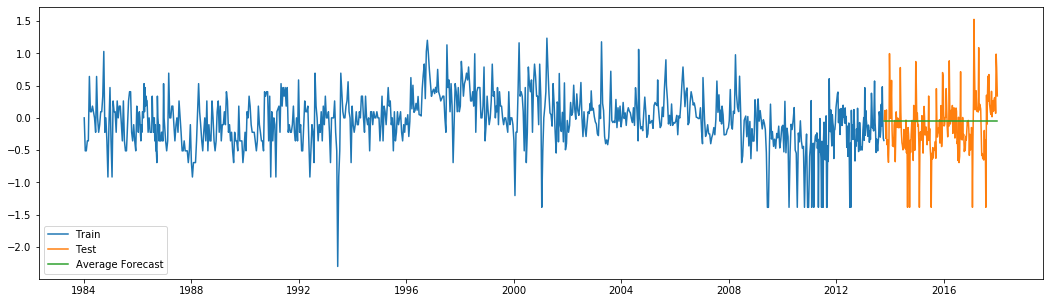

In [20]:
#prediction  average
y_hat_avg = test.copy()
y_hat_avg['avg_forecast'] = train['DOC'].mean()
plt.figure(figsize=(18,5))
plt.plot(train['DOC'], label='Train')
plt.plot(test['DOC'], label='Test')
plt.plot(y_hat_avg['avg_forecast'], label='Average Forecast')
plt.legend(loc='best')
plt.show()

In [21]:
rms = sqrt(mean_squared_error(test.DOC, y_hat_avg.avg_forecast))
print( "RSME",rms)

RSME 0.43881130638411586


______________________________________________________________________________________________________________________

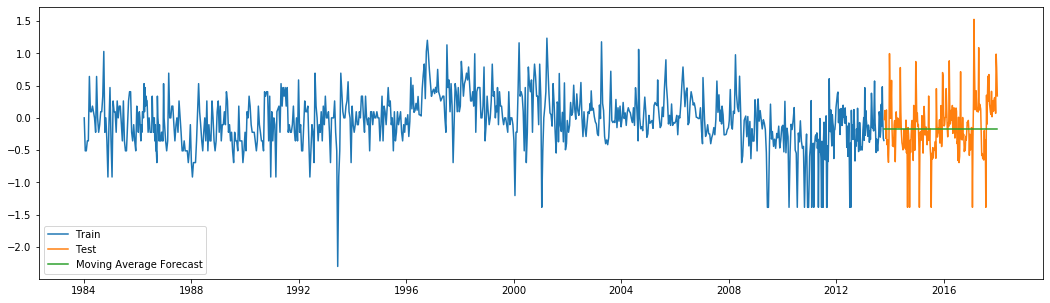

In [22]:
#prediction moving average
y_hat_avg = test.copy()
y_hat_avg['moving_avg_forecast'] = train['DOC'].rolling(60).mean().iloc[-1]
plt.figure(figsize=(18,5))
plt.plot(train['DOC'], label='Train')
plt.plot(test['DOC'], label='Test')
plt.plot(y_hat_avg['moving_avg_forecast'], label='Moving Average Forecast')
plt.legend(loc='best')
plt.show()

In [23]:
rms = sqrt(mean_squared_error(test.DOC, y_hat_avg.moving_avg_forecast))
print("RSME",rms)

RSME 0.4326667431472504


______________________________________________________________________________________________________________________

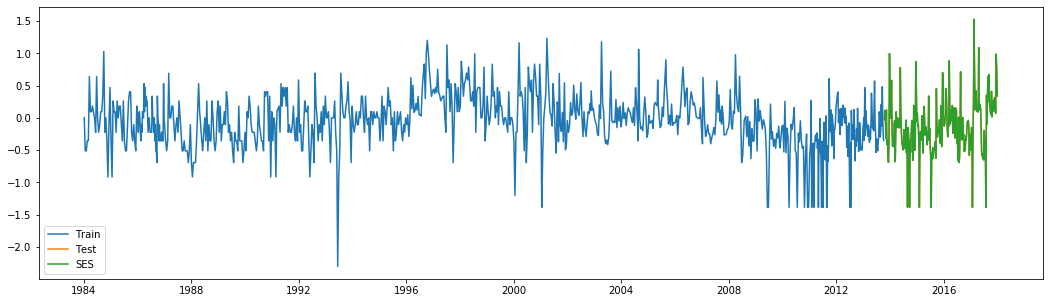

In [24]:
#prediction simple exponential smoothing
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
y_hat_avg = test.copy()
fit2 = SimpleExpSmoothing(np.asarray(train['DOC'])).fit(smoothing_level=0.6,optimized=False)
y_hat_avg['SES'] = fit2.forecast(len(test))
plt.figure(figsize=(18,5))
plt.plot(train['DOC'], label='Train')
plt.plot(test['DOC'], label='Test')
plt.plot(y_hat_avg['DOC'], label='SES')
plt.legend(loc='best')
plt.show()

In [25]:
rms = sqrt(mean_squared_error(test.DOC, y_hat_avg.SES))
print("RMSE",rms)


RMSE 0.45290495478736503


______________________________________________________________________________________________________________________

C:\Users\raiko\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: the 'freq' keyword is deprecated, use 'period' instead
  


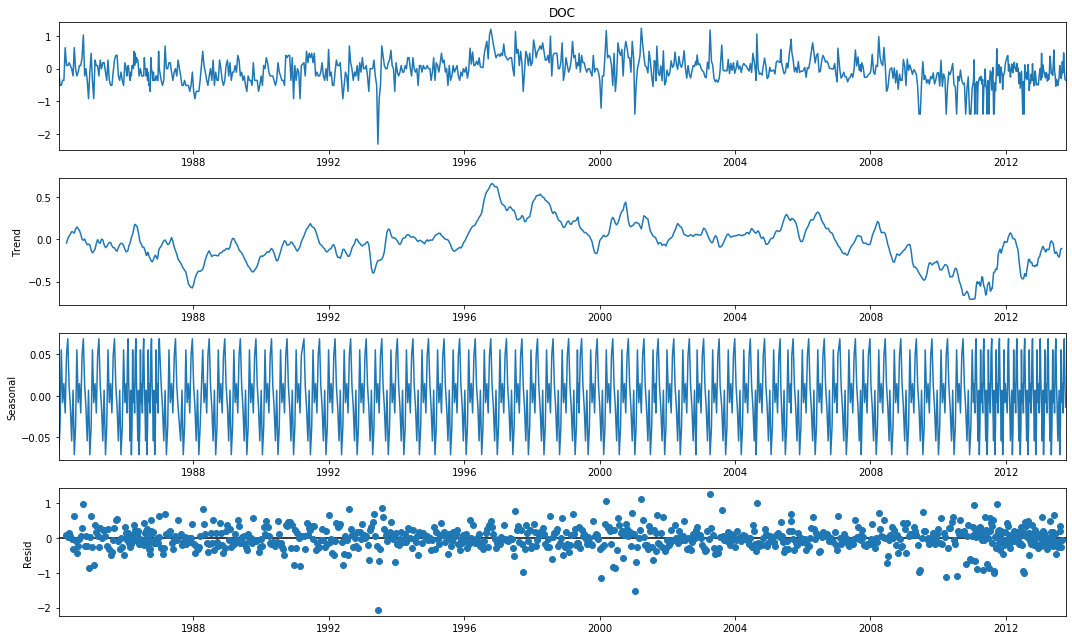

In [26]:
import statsmodels.api as sm
sm.tsa.seasonal_decompose(train.DOC,freq=12).plot()
result = sm.tsa.stattools.adfuller(train.DOC)
plt.show()

C:\Users\raiko\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


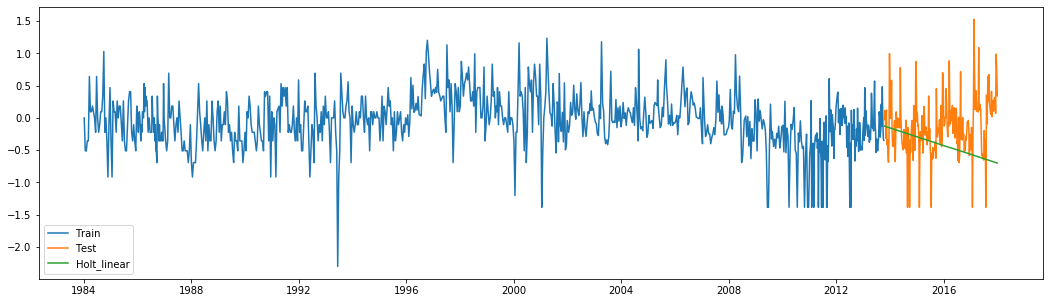

In [27]:
#prediction Holt linears trend

y_hat_avg = test.copy()

fit1 = Holt(np.asarray(train['DOC'])).fit(smoothing_level = 0.3,smoothing_slope = 0.1)
y_hat_avg['Holt_linear'] = fit1.forecast(len(test))

plt.figure(figsize=(18,5))
plt.plot(train['DOC'], label='Train')
plt.plot(test['DOC'], label='Test')
plt.plot(y_hat_avg['Holt_linear'], label='Holt_linear')
plt.legend(loc='best')
plt.show()

In [28]:
rms = sqrt(mean_squared_error(test.DOC, y_hat_avg.Holt_linear))
print("RSME",rms)

RSME 0.5682380639642585


______________________________________________________________________________________________________________________

C:\Users\raiko\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:725: RuntimeWarning: invalid value encountered in less_equal
  loc = initial_p <= lb
C:\Users\raiko\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


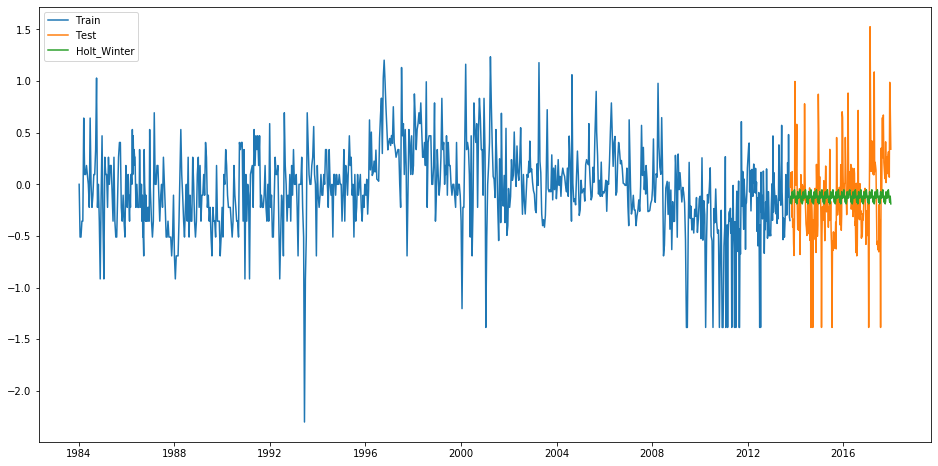

In [29]:
# prediction holt winters
y_hat_avg = test.copy()
fit1 = ExponentialSmoothing(np.asarray(train['DOC']) ,seasonal_periods=12 ,trend='add', seasonal='add',).fit()
y_hat_avg['Holt_Winter'] = fit1.forecast(len(test))
plt.figure(figsize=(16,8))
plt.plot( train['DOC'], label='Train')
plt.plot(test['DOC'], label='Test')
plt.plot(y_hat_avg['Holt_Winter'], label='Holt_Winter')
plt.legend(loc='best')
plt.show()

In [30]:
rms = sqrt(mean_squared_error(test.DOC, y_hat_avg.Holt_Winter))
print("RSME", rms)

RSME 0.4372715703638042


______________________________________________________________________________________________________________________

#arima parameters
p=periods, taken into account for autor egression, prediction
d = integratedorder, how many times differenceing 8typiclly 1 or 2
q = periods in moving average model

In [31]:
from statsmodels.tsa.arima_model import ARIMA

In [32]:
model_arima= ARIMA(train, order=(12,1,1))
model_arima_fit=model_arima.fit()

C:\Users\raiko\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\raiko\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [33]:
prediction = model_arima_fit.forecast(steps=219)[0]

C:\Users\raiko\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


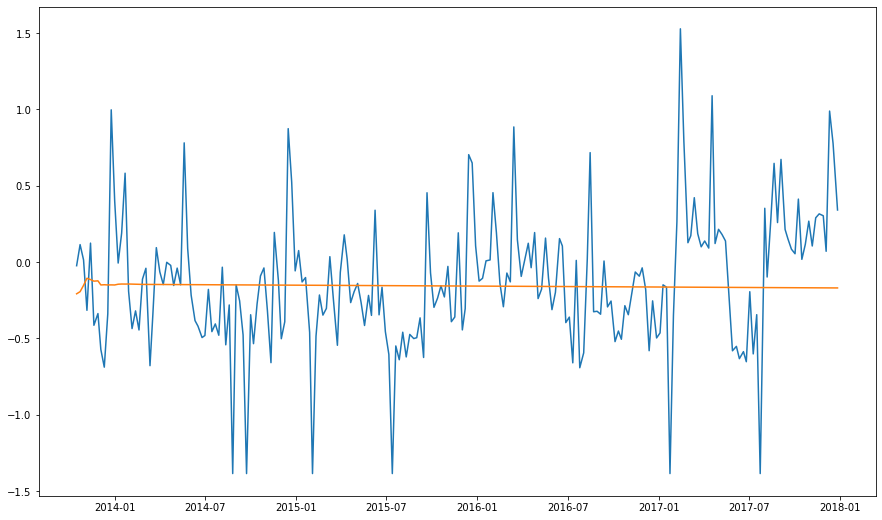

In [34]:
test["Prediction"]=prediction
plt.plot(test)

In [72]:
rms = sqrt(mean_squared_error(test.DOC, test.Prediction))
print("RSME", rms)

RSME 0.43386150665562073


_______________________________________


In [35]:
#with auto_arima model fitting

In [44]:
import pmdarima as pmd
from pmdarima import auto_arima

In [46]:
stepwise_model = auto_arima(ts_log, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

Performing stepwise search to minimize aic
Fit ARIMA: (1, 1, 1)x(0, 1, 1, 12) (constant=True); AIC=923.948, BIC=948.871, Time=11.437 seconds
Fit ARIMA: (0, 1, 0)x(0, 1, 0, 12) (constant=True); AIC=2036.498, BIC=2046.467, Time=0.384 seconds
Fit ARIMA: (1, 1, 0)x(1, 1, 0, 12) (constant=True); AIC=1539.158, BIC=1559.097, Time=3.501 seconds
Fit ARIMA: (0, 1, 1)x(0, 1, 1, 12) (constant=True); AIC=1009.775, BIC=1029.714, Time=6.208 seconds
Near non-invertible roots for order (0, 1, 1)(0, 1, 1, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.994)
Fit ARIMA: (0, 1, 0)x(0, 1, 0, 12) (constant=False); AIC=2034.498, BIC=2039.483, Time=0.196 seconds
Fit ARIMA: (1, 1, 1)x(0, 1, 0, 12) (constant=True); AIC=1589.508, BIC=1609.447, Time=5.509 seconds
Near non-invertible roots for order (1, 1, 1)(0, 1, 0, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (1, 1, 1)x(1, 1, 1, 12) (constant=

In [73]:
stepwise_model=stepwise_model.fit(train)

In [77]:
future_forecast = stepwise_model.predict(n_periods=219)[0]
future_forecast = pd.DataFrame(future_forecast,index = test.index,columns=["Prediction"])

<Figure size 1296x720 with 0 Axes>

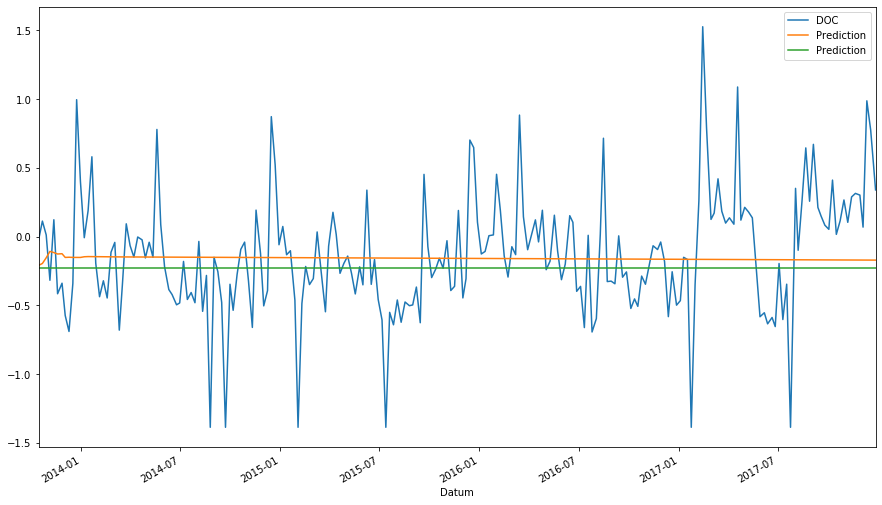

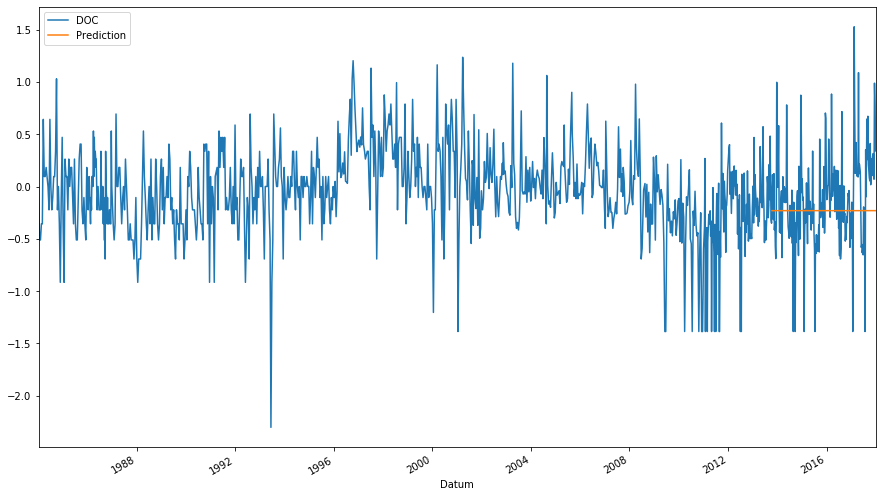

In [78]:

plt.figure(figsize=(18,10))

pd.concat([test,future_forecast],axis=1).plot()

pd.concat([ts_log,future_forecast],axis=1).plot()

In [79]:
rms = sqrt(mean_squared_error(test.DOC, future_forecast.Prediction))
print("RSME", rms)

RSME 0.442006658704251
